In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from configuration import constants

from scipy.interpolate import interp1d

HEALTHY = constants.HEALTHY
INFECTED = constants.INFECTED
SUSCEPTIBLE = constants.SUSCEPTIBLE
CURED = constants.CURED
DEAD = constants.DEAD
INFANT_DEATH = constants.INFANT_DEATH
CHILD_DEATH = constants.CHILD_DEATH
HBV_DEATH = constants.HBV_DEATH
MATERNAL_DEATH = constants.MATERNAL_DEATH

LABELS = ['Vaccination rate=0.8', 'Vaccination rate=0.9', 'Vaccination rate=0.95']

In [2]:
import cPickle
from os.path import join

def collect_multi_run_stats(folder):
    
    with open(join(folder, 'collective_mother_stats.pkl'), 'rb') as f:
        mother_stats_config = cPickle.load(f)

    with open(join(folder, 'collective_children_stats.pkl'), 'rb') as f:
        children_stats_config = cPickle.load(f)
        
    return mother_stats_config, children_stats_config

mother_config_1, children_config_1 = collect_multi_run_stats('config_1')
mother_config_2, children_config_2 = collect_multi_run_stats('config_2')
mother_config_3, children_config_3 = collect_multi_run_stats('config_3')

In [3]:
def plot_yearly_stat(yearly_stats, xlabels, ylabels, title):
    
    fig, ax = plt.subplots(figsize=(14,5))
    x_ticks = len(years)
    idx = np.arange(x_ticks)
    width = 0.35

    for idx in range(0, yearly_stats.shape[0]):
        ax.plot(xlabels, yearly_stats[idx,:], label=ylabels[idx] )
    
    ax.set_xlabel('years')
    ax.set_ylabel('population')
    ax.legend(loc='best')
    fig.suptitle(title)
    plt.show()

In [15]:
def collect_yearly_stats(stat_collection, status, years):
    yearly_stats = list() #np.zeros((len(mother_status), len(years)))
    for m_idx, m in enumerate(status):
        for y_idx, y in enumerate(years):
            yearly_stats.append(stat_collection[m][y][1:])
    return yearly_stats

def get_means(yearly_stats, years):
    
    number_configs = len(yearly_stats)
    
    means = []
    std_ys = []
    interpolators = []
    interpolators_up = []
    interpolators_down = []
    
    for r in range(number_configs):

        y_stat = yearly_stats[r]
        y_stat = np.array(y_stat)
        mean_y = np.mean(y_stat, axis = 1)
        std_y = np.std(y_stat, axis=1)
        
        means.append(mean_y)
        std_ys.append(std_y)
        
        interpolators.append(interp1d(years, mean_y, kind='cubic'))
        interpolators_up.append(interp1d(years[1:], (mean_y+std_y)[1:], kind='cubic', fill_value='extrapolate'))
        interpolators_down.append(interp1d(years[1:], (mean_y-std_y)[1:], kind='cubic', fill_value='extrapolate'))
        
        
    return means, std_ys, interpolators, interpolators_up, interpolators_down
        
        

def plot_yearly_stats(yearly_stats, years, filename = None, normalizer=1000, labels=None, ylabel_suffix = None):
    
    number_configs = len(yearly_stats)
    
    #grid = GridSpec(1,number_configs)
    
    year_label = [yr+2018 for yr in years]
    
    means, stdys, interpolators, i_up, i_down = get_means(yearly_stats, years)
    
    fig, ax = plt.subplots(figsize=(21,21))
    max_y=-1
    plotted_years = np.arange(1, 12, 0.1)
    for r in range(number_configs):
        
        mean_y = means[r]
        std_y = stdys[r]
        mean_y = np.array(mean_y, dtype=np.float)
        interpolator = interpolators[r]
        iup = i_up[r]
        idn = i_down[r]
        
        plotted_y = interpolator(plotted_years)
        plotted_y_up = iup(plotted_years)
        plotted_y_dn = idn(plotted_years)
        
        if max_y < np.max(mean_y):
            max_y = np.max(mean_y)
        
        
        #ax = plt.subplot(grid[0,r])
        ax.errorbar(years, mean_y/normalizer, std_y/normalizer, fmt='o', elinewidth=3, capsize=5, markersize=6 )
        
        if labels is not None:
            ax.plot(plotted_years, plotted_y/normalizer, linewidth = 4, label = labels[r])
        else:
            ax.plot(plotted_years, plotted_y/normalizer, linewidth = 4)
            
        #ax.fill_between(plotted_years, plotted_y_dn/normalizer, plotted_y_up/normalizer)
    
    number_labels = np.arange(0, (max_y+1*normalizer)/normalizer+15, 10) #children=10, mothers=20
    ax.set_xticks(years)
    ax.set_xticklabels(year_label, fontsize=20)
    ax.set_yticks(number_labels)
    ax.set_yticklabels(number_labels, fontsize=20)
    #ax.xticks(years, year_label)
    ax.set_xlabel('Years', fontsize=20)
    ax.set_ylabel('Population Number{0}'.format(ylabel_suffix), fontsize=20)
    ax.set_ylim([0, number_labels[-1]])
    
    if labels is not None:
        ax.legend(loc='best',prop={'size': 18})
    
    if filename is not None:
        plt.savefig(filename)
    return fig

def plot_genders(yearly_stats, years, gender_ratio, filename = None, normalizer=1000, ylabel_suffix = None):
    
    number_configs = len(yearly_stats)
    
    #grid = GridSpec(1,number_configs)
    
    year_label = [yr+2018 for yr in years]
    
    means, _, interpolators, _, _ = get_means(yearly_stats, years)
    
    fig, ax = plt.subplots(figsize=(21,21))
    max_y=-1
    plotted_years = np.arange(1, 12, 0.1)
    for r in range(number_configs):
        
        mean_y = means[r]
        mean_y = np.array(mean_y, dtype=np.float)
        interpolator = interpolators[r]
        
        plotted_y = interpolator(plotted_years)
        
        if max_y < np.max(mean_y):
            max_y = np.max(mean_y)
        
        #ax = plt.subplot(grid[0,r])
        ax.plot(years, mean_y/normalizer, 'o', markersize=6 )
        
        ax.plot(plotted_years, plotted_y/normalizer, linewidth = 4)
            
        male = plotted_y * gender_ratio[0]/(gender_ratio[0]+gender_ratio[1])
        ax.fill_between(plotted_years, male/normalizer, label='Male', alpha=0.6)
        ax.fill_between(plotted_years, plotted_y/normalizer, male/normalizer, alpha=0.6, label='Female')
    
    number_labels = np.arange(0, (max_y+1*normalizer)/normalizer+15, 10) #children=10, mothers=20
    ax.set_xticks(years)
    ax.set_xticklabels(year_label, fontsize=20)
    ax.set_yticks(number_labels)
    ax.set_yticklabels(number_labels, fontsize=20)
    #ax.xticks(years, year_label)
    ax.set_xlabel('Years', fontsize=20)
    ax.set_ylabel('Population Number{0}'.format(ylabel_suffix), fontsize=20)
    ax.set_ylim([0, number_labels[-1]])
    
    ax.legend(loc='best',prop={'size': 18})
    
    if filename is not None:
        plt.savefig(filename)
    return fig

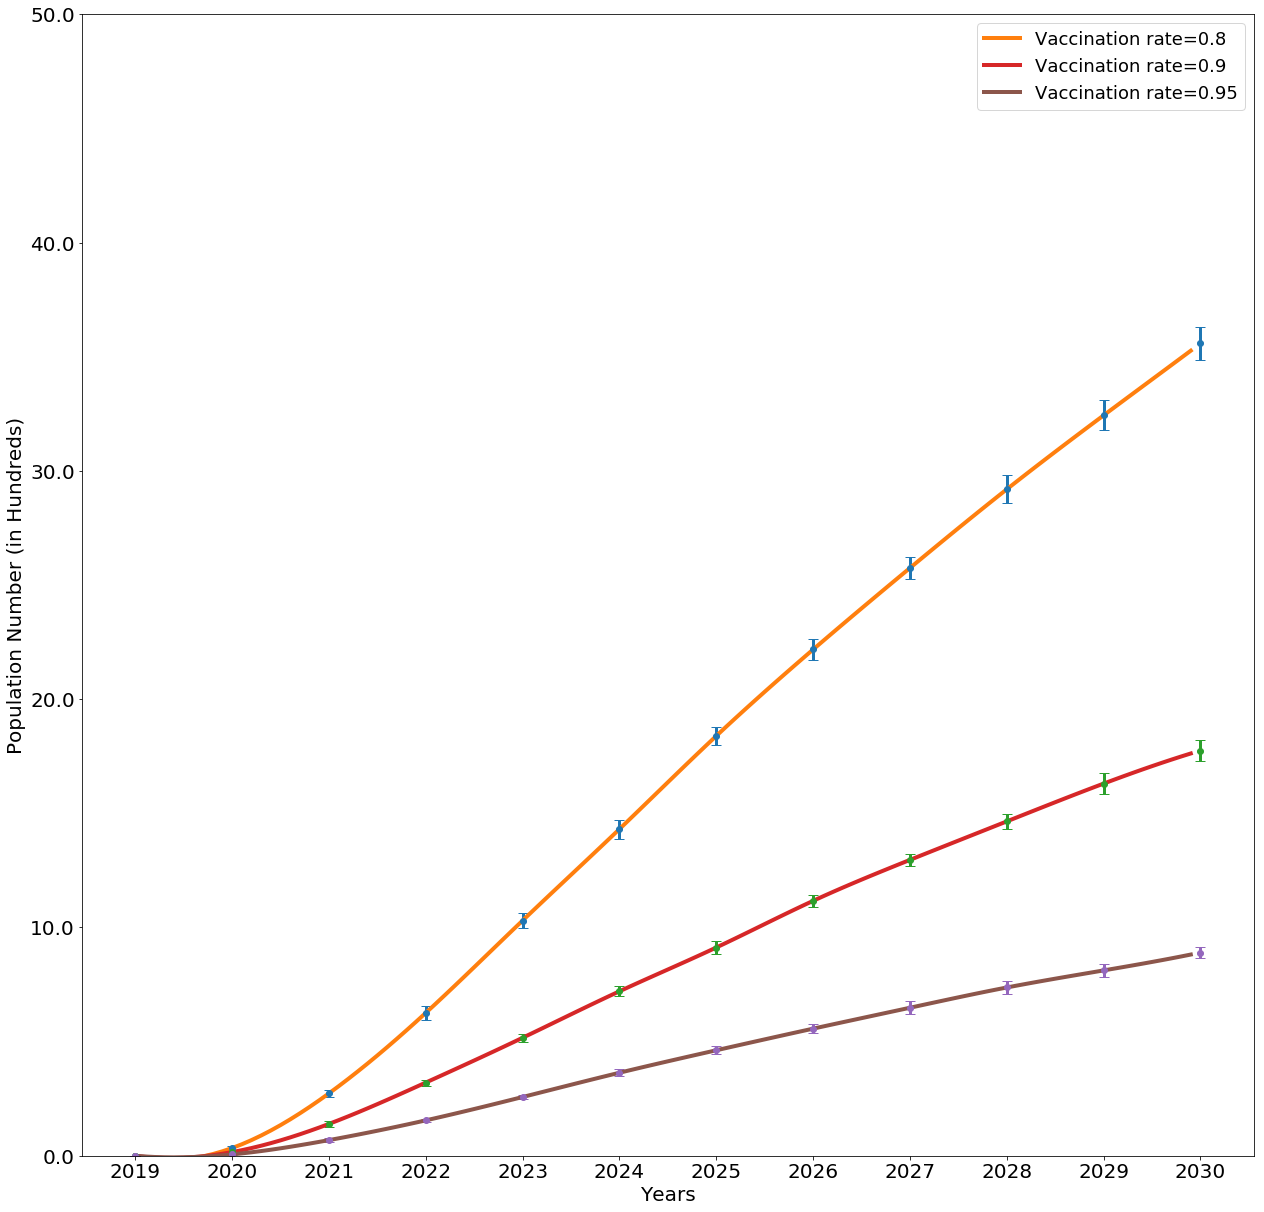

In [20]:
children_status = [CURED] #[HEALTHY, INFECTED,SUSCEPTIBLE,CURED, INFANT_DEATH, CHILD_DEATH, HBV_DEATH, DEAD]
years = [i for i in range(1,13)]

children_stats_config_1 = collect_yearly_stats(children_config_1, children_status, years)
children_stats_config_2 = collect_yearly_stats(children_config_2, children_status, years)
children_stats_config_3 = collect_yearly_stats(children_config_3, children_status, years)

filename='children_{0}.svg'.format(children_status[0])
fig=plot_yearly_stats([children_stats_config_1, children_stats_config_2, children_stats_config_3], 
                      years, filename=filename, normalizer=100, labels = LABELS, ylabel_suffix= ' (in Hundreds)')

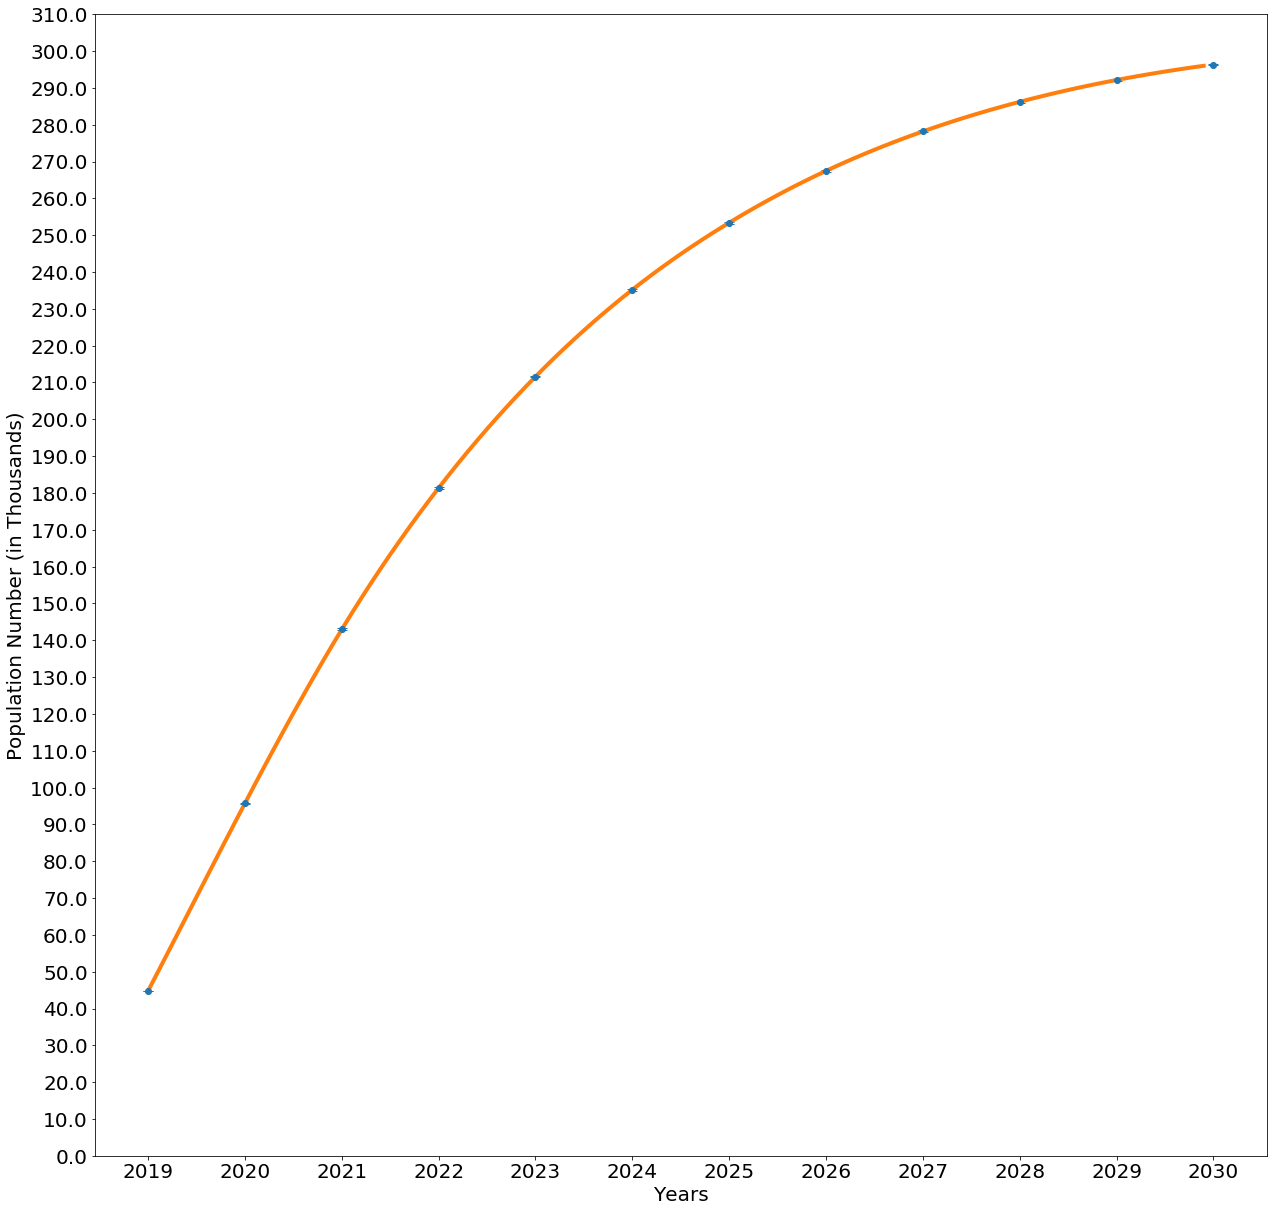

In [24]:
mother_status = [CURED] #[HEALTHY, SUSCEPTIBLE, INFECTED, CURED, DEAD, MATERNAL_DEATH]
years = [i for i in range(1,13)]

mother_stats_config_1 = collect_yearly_stats(mother_config_1, mother_status, years)
mother_stats_config_2 = collect_yearly_stats(mother_config_2, mother_status, years)
mother_stats_config_3 = collect_yearly_stats(mother_config_3, mother_status, years)

info_array = np.array(mother_stats_config_1)

#fig, ax = plt.subplots()
#ax.boxplot(mother_stats_config_1[1:])
#_ = plot_yearly_stats([mother_stats_config_1, mother_stats_config_2, mother_stats_config_3], years)
filename='mother_{0}.svg'.format(mother_status[0])
fig=plot_yearly_stats([mother_stats_config_1], 
                      years, filename=filename, normalizer=1000, labels = None, ylabel_suffix= ' (in Thousands)')

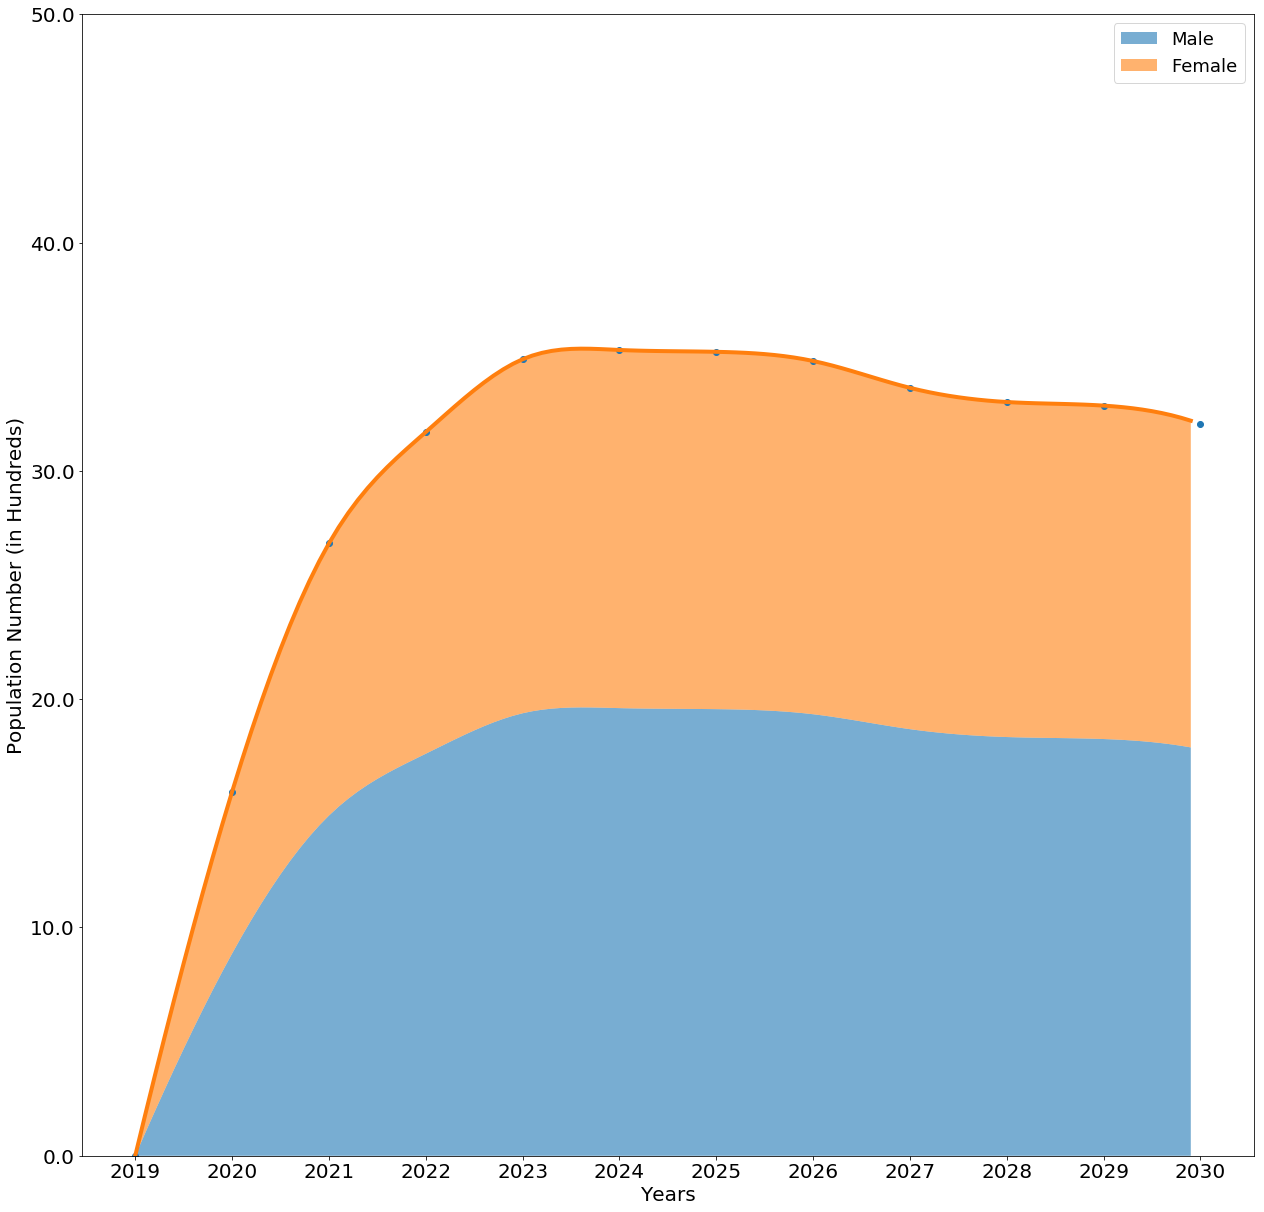

In [18]:
children_status = [HBV_DEATH] #[HEALTHY, INFECTED,SUSCEPTIBLE,CURED, INFANT_DEATH, CHILD_DEATH, HBV_DEATH, DEAD]
years = [i for i in range(1,13)]

children_stats_config_1 = collect_yearly_stats(children_config_1, children_status, years)
#children_stats_config_2 = collect_yearly_stats(children_config_2, children_status, years)
#children_stats_config_3 = collect_yearly_stats(children_config_3, children_status, years)

filename='gender_{0}_{1}.svg'.format(children_status[0], LABELS[0])
fig = plot_genders([children_stats_config_1], years, gender_ratio=[10,8], filename = filename, 
                   normalizer=100, ylabel_suffix = ' (in Hundreds)')